# LEVITAS — Phase 1 Simulation
## Active Magnetic Levitation via Feedback Control

This notebook simulates a **1D active magnetic levitation system** to demonstrate:

- Open-loop instability of magnetic levitation
- Stabilization using feedback control (PD controller)
- Nonlinear dynamics arising from magnetic force dependence on distance

The model is intentionally minimal yet physically grounded.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


## Physical Parameters

The following constants define the physical system:
- Object mass
- Gravity
- Magnetic force constant
- Desired levitation height


In [2]:
# Physical constants
g = 9.81          # gravity (m/s^2)
m = 0.05          # mass (kg)
k = 1e-5          # magnetic force constant

# Control parameters
x_ref = 0.02      # desired levitation height (m)
i0 = 1.5          # nominal coil current (A)

Kp = 120.0        # proportional gain
Kd = 8.0          # derivative gain


## System Model

Magnetic force approximation:

\[
F_m(x, i) = \frac{k i^2}{x^2}
\]

Equation of motion:

\[
m\ddot{x} = F_m(x, i) - mg
\]

This nonlinear system is **open-loop unstable**.


In [3]:
def magnetic_force(x, i):
    return k * (i ** 2) / (x ** 2)


def pd_controller(x, x_dot):
    error = x_ref - x
    return Kp * error - Kd * x_dot


def maglev_step(state, dt, control=True):
    x, x_dot = state

    if control:
        u = pd_controller(x, x_dot)
    else:
        u = 0.0

    i = i0 + u
    i = max(i, 0.0)

    Fm = magnetic_force(x, i)
    x_ddot = (Fm / m) - g

    x_dot_next = x_dot + x_ddot * dt
    x_next = x + x_dot_next * dt

    return np.array([x_next, x_dot_next])


## Simulation Setup

We simulate the system starting slightly away from equilibrium to observe:
- Divergence in open-loop
- Stabilization under feedback control


In [4]:
dt = 0.0005
T = 1.5
time = np.arange(0, T, dt)

initial_state = np.array([0.018, 0.0])  # slight offset

## Open-Loop Simulation (No Control)

The current is held constant.
The system should diverge from equilibrium.


In [5]:
states_open = np.zeros((len(time), 2))
states_open[0] = initial_state

for t in range(1, len(time)):
    states_open[t] = maglev_step(states_open[t-1], dt, control=False)


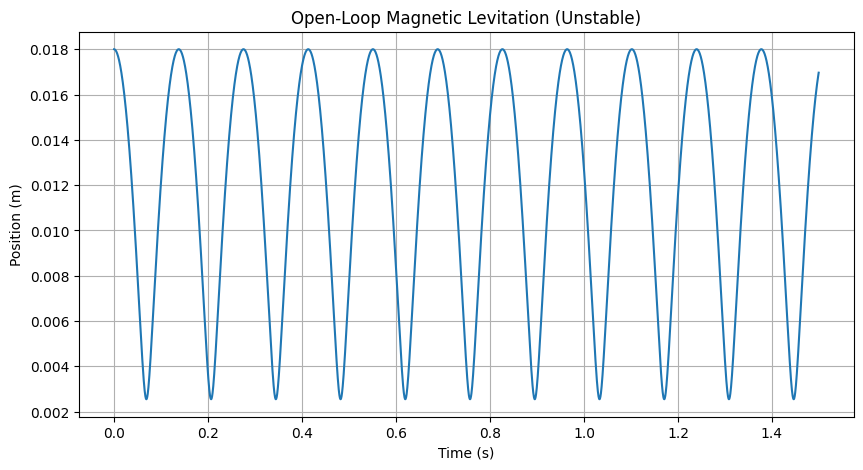

In [6]:
plt.plot(time, states_open[:, 0])
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Open-Loop Magnetic Levitation (Unstable)")
plt.show()


## Closed-Loop Simulation (PD Control)

Feedback control adjusts the current in real time to stabilize levitation.


In [7]:
states_closed = np.zeros((len(time), 2))
states_closed[0] = initial_state

for t in range(1, len(time)):
    states_closed[t] = maglev_step(states_closed[t-1], dt, control=True)


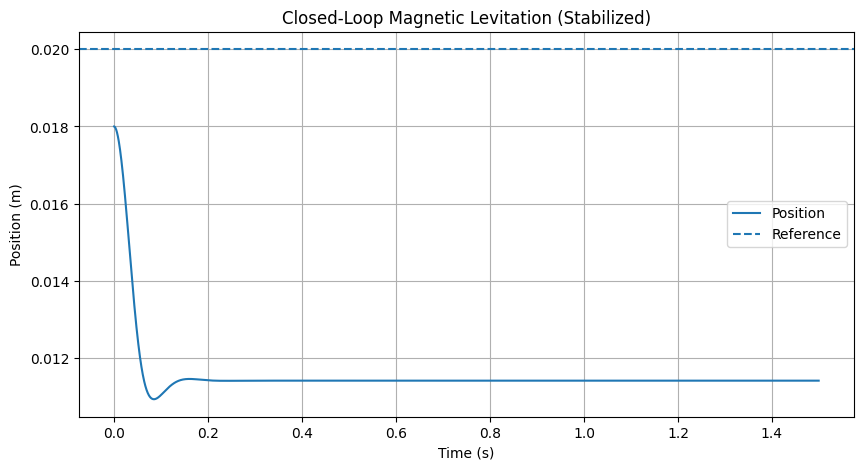

In [8]:
plt.plot(time, states_closed[:, 0], label="Position")
plt.axhline(x_ref, linestyle="--", label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Closed-Loop Magnetic Levitation (Stabilized)")
plt.legend()
plt.show()


## Control Effort

Examining how the control signal behaves over time.


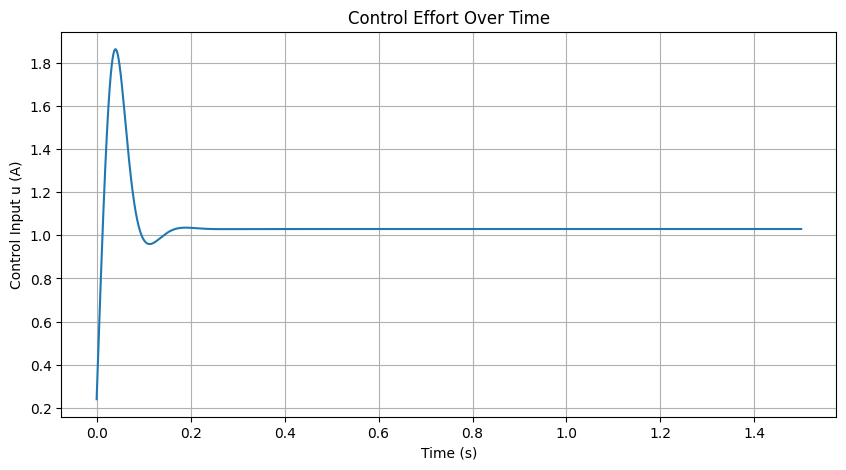

In [9]:
control_signal = []

for x, x_dot in states_closed:
    control_signal.append(pd_controller(x, x_dot))

control_signal = np.array(control_signal)

plt.plot(time, control_signal)
plt.xlabel("Time (s)")
plt.ylabel("Control Input u (A)")
plt.title("Control Effort Over Time")
plt.show()


## Observations

- Open-loop magnetic levitation is unstable.
- Feedback control stabilizes the system around the desired height.
- The nonlinear force-distance relationship is central to instability.
- Control gains strongly affect oscillations and settling time.

This validates the core principle of LEVITAS:
**stable magnetic levitation requires active feedback control.**
